# GD: 6. 임베딩 내 편향성 알아보기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Word Embedding Association Test (WEAT)로 단어 임베딩 편향성 평가하기!

### 1.  IAT(Implicit Association Test) 라는 인지편향성 실험 구조에 기반
### 2. X-Y, A-B 두 개념축을 설정
### 3. Target dataset, 상반되는 두 attribute dataset을 각각 이어 두 축을 만들어
### 4. 두 target 단어와 두 attribute 축까지의 거리를 통해 편향성 측정

In [ ]:
import os

with open('/content/drive/MyDrive/gd06/synopsis/synopsis.txt', 'r') as file:
    for i in range(20):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.
 은수를 잊지 못하는 상우는 미련과 집착의 감정을 이기지 못하고 서울과 강릉을 오간다.
유사 이래 연령, 성별, 빈부의 차이와 정치적인 입장을 불문하고 일거에 국민을 통합해 온 '애국심'이라는 성역에 일침을 가하는 다큐멘터리. 재작년 전국 민족민주 유가족협의회의 장기농성을 다룬 인상적인 다큐멘터리 <민들레>를 만들었던 독립영화집단 '빨간 눈사람'이 우리 사회 구석구석을 발빠르게 돌아다니며 애국심과 민족주의가 강요되는 현장을 발굴하여 카메라에 담았다. 박홍 서강대 명예총장, 이도형 '한국논단' 발행인, 축구해설자 신문선, 홍세화, 박노해 등 사회 각계의 '스타'들이 등장해 저마다의 확고한 신념을 성토한다. 감독 이경순과 최하동하는 이 작품을 위해 3년간 백여 명을 인터뷰했다고 한다. 2001 올해의 독립영화상 수상.
 민족과 국가란 공동체에서 부단히 권력과 부를 얻는 자, 나아가 민족과 국가란 공동체에서 얻은 신분과 부귀를 영원히 그의 자손에게 대물림하려는 자, 그래서 민족과 국가란 공동체를 부단히 유지해야만 하는 자, 따라서

In [ ]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from konlpy.tag import Okt
okt = Okt()
tokenized = []
with open('/content/drive/MyDrive/gd06/synopsis/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()  
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

In [ ]:
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)  
model.wv.most_similar(positive=['영화'])

[('작품', 0.9122476577758789),
 ('다큐멘터리', 0.8651312589645386),
 ('드라마', 0.8347333669662476),
 ('영화로', 0.8300831913948059),
 ('코미디', 0.8230233192443848),
 ('형식', 0.8102147579193115),
 ('감동', 0.8063133955001831),
 ('주제', 0.7980839014053345),
 ('영상', 0.7960461378097534),
 ('스토리', 0.7904072999954224)]

In [ ]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt

art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
    okt = Okt()
    result = []
    with open('/content/drive/MyDrive/gd06/synopsis/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

In [ ]:
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


## Okt를 통해 태깅한 명사들을 tf-idf matrix로 변환

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [ ]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

## 각각 15개씩 단어들을 추출

In [ ]:
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Gener를 target으로 설정하여 모든 장르간 편향성 측정

In [ ]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [ ]:
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42191)


# 장르별 단어 추출

In [ ]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 위해, 자신, 지구, 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 
드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 
뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 
미스터리: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 
범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 
사극: 조선, 위해, 시작, 신기전, 사랑, 자신, 아가멤논, 황제, 그녀, 루안, 최고, 운명, 사람, 하선, 전쟁, 
서부극(웨스턴): 서부, 보안관, 위해, 벌린, 카우보이, 그레이프바인, 헨리, 마을, 자신, 개릿, 아이, 시작, 무법자, 프린트, 마적, 
성인물(에로): 그녀, 남편, 마사지, 자신, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀, 마음, 사랑, 
스릴러: 자신, 그녀, 사건, 시작, 위해, 사람, 살인, 

In [ ]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

## WEAT-score 정의

In [ ]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

In [ ]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

# WEAT SCORE 구하기

In [ ]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])

SF 가족 -0.5197868
SF 공연 -0.3533054
SF 공포(호러) -0.6753175
SF 기타 0.33784798
SF 다큐멘터리 0.56877226
SF 드라마 -0.36429152
SF 멜로로맨스 -0.7800307
SF 뮤지컬 0.34310457
SF 미스터리 -0.6684472
SF 범죄 -0.2219378
SF 사극 -0.8407296
SF 서부극(웨스턴) -0.44333473
SF 성인물(에로) -0.5778846
SF 스릴러 -0.51412827
SF 애니메이션 0.34713423
SF 액션 -0.45742825
SF 어드벤처 -0.76021624
SF 전쟁 0.23528779
SF 코미디 -0.4528515
SF 판타지 -0.18291788
가족 공연 0.23214315
가족 공포(호러) -0.17711067
가족 기타 0.75135624
가족 다큐멘터리 0.8146395
가족 드라마 0.22698718
가족 멜로로맨스 -0.621817
가족 뮤지컬 0.7133164
가족 미스터리 -0.29390556
가족 범죄 0.21807875
가족 사극 -0.08441373
가족 서부극(웨스턴) 0.38069198
가족 성인물(에로) -0.34071374
가족 스릴러 -0.13628751
가족 애니메이션 0.85386455
가족 액션 0.114177234
가족 어드벤처 -0.0063957614
가족 전쟁 0.6632299
가족 코미디 0.17581601
가족 판타지 0.4269261
공연 공포(호러) -0.27588892
공연 기타 0.9263797
공연 다큐멘터리 0.9023238
공연 드라마 -0.023112206
공연 멜로로맨스 -0.70220447
공연 뮤지컬 0.8919439
공연 미스터리 -0.35990825
공연 범죄 0.0705681
공연 사극 -0.40239716
공연 서부극(웨스턴) -0.023795428
공연 성인물(에로) -0.50592107
공연 스릴러 -0.22876227
공연 애니메이션 0.899723
공연 액션 -

In [ ]:
genre[0]

'시간 지명 알 수 한국 가상 도시 산성비 오염 이 도시 기억 망각 바이러스 존재 소문 시작 기억 위해 사람 곳 어 두운 기억 안나 역시 망각 바이러스 그녀 사람 바이러스 가이드 유키 고아 출신 여행사 소속 택시 운전사 나비 떼 바이러스 지역 인도 정보 산성비 위험 무릅쓰 세 사람 도착 곳 공사 현장 곳 안나 나비 떼 가이드 또한 그 구슬 소리 등 분위기 자신 기억 환각 속 한편 가이드 유키 납중독 상태 임 임신 개월 아이 것 알 안나 그녀 하나 인연 끈 유키 유키 산성비 노출 안나 정성껏 자신 캡슐 하우스 영상 기억 자신 누군가 기억 바랬던 소녀 셀프 비디오 또한 망각 바이 스 기억 사람 간 여권 안나 기억 자신 간직 안나 망각 향 돌진 자신 뒤 유케 묘 우정 유키 평소 사이 택시 운전사 의 신고 납중독 환자 격리 소 안나 둘이서 여행 계속 의 무례 합승 안나 감정 폭발 안나 고아 자신 누군가 기억 가족 수 희망 때문 합승 계속 고백 기억 안나 정반대 자신 기억 누군가 의 여행 계속 서로 모습 인생 의미 두 사람 여행 의 택시 추락 중단 후 새 휴양지 향 안나 돌연 발길 요양소 억류 유키 자신 모든 경비 그녀 빼 유키 소망 위해 바다로 안나 바다 속 유키 아기 음 두 사람 기적 사망 유키 유품 정리 위해 그녀 집 안나 발견 것 상사 낙 오직 게임방 게임 것 중국집 배달 주 김현성 분 여느 때 게임 성냥 팔이 소녀 재림 게임 접속 것 권고 동화 속 등장 성냥 팔이 소녀 이 게임 속 재현 현실 세계 성냥 팔이 소녀 가상 공간 현실 가상 공간 혼재 가운데 주의 임무 갖가지 외부 위험 성냥 팔이 소녀 구해 동화 속 성냥 팔이 소녀 죽음 유도 것 여기 조종 배후 체인 시스템 방해 뿐 성냥 팔이 소녀 위협 여러가지 방해 신학교 교수 칼라일 그리스도 가르침 기준 자신 책 발간 위 동료 학장 동의 구한 모두 적극 찬성 표 그 의견 반대 노 리스 교수 그 그 이유 노 리스 자신 집 칼라일 초대 노 리스 집 칼라일 치 시간 여행 경험 미래 살 사람 삶 충격 알렉산더 하트 겐 

In [ ]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [ ]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [ ]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])

SF 가족 -0.5197868
SF 공연 -0.3533054
SF 공포(호러) -0.6753175
SF 기타 0.33784798
SF 다큐멘터리 0.56877226
SF 드라마 -0.36429152
SF 멜로로맨스 -0.7800307
SF 뮤지컬 0.34310457
SF 미스터리 -0.6684472
SF 범죄 -0.2219378
SF 사극 -0.8407296
SF 서부극(웨스턴) -0.44333473
SF 성인물(에로) -0.5778846
SF 스릴러 -0.51412827
SF 애니메이션 0.34713423
SF 액션 -0.45742825
SF 어드벤처 -0.76021624
SF 전쟁 0.23528779
SF 코미디 -0.4528515
SF 판타지 -0.18291788
가족 공연 0.23214315
가족 공포(호러) -0.17711067
가족 기타 0.75135624
가족 다큐멘터리 0.8146395
가족 드라마 0.22698718
가족 멜로로맨스 -0.621817
가족 뮤지컬 0.7133164
가족 미스터리 -0.29390556
가족 범죄 0.21807875
가족 사극 -0.08441373
가족 서부극(웨스턴) 0.38069198
가족 성인물(에로) -0.34071374
가족 스릴러 -0.13628751
가족 애니메이션 0.85386455
가족 액션 0.114177234
가족 어드벤처 -0.0063957614
가족 전쟁 0.6632299
가족 코미디 0.17581601
가족 판타지 0.4269261
공연 공포(호러) -0.27588892
공연 기타 0.9263797
공연 다큐멘터리 0.9023238
공연 드라마 -0.023112206
공연 멜로로맨스 -0.70220447
공연 뮤지컬 0.8919439
공연 미스터리 -0.35990825
공연 범죄 0.0705681
공연 사극 -0.40239716
공연 서부극(웨스턴) -0.023795428
공연 성인물(에로) -0.50592107
공연 스릴러 -0.22876227
공연 애니메이션 0.899723
공연 액션 -

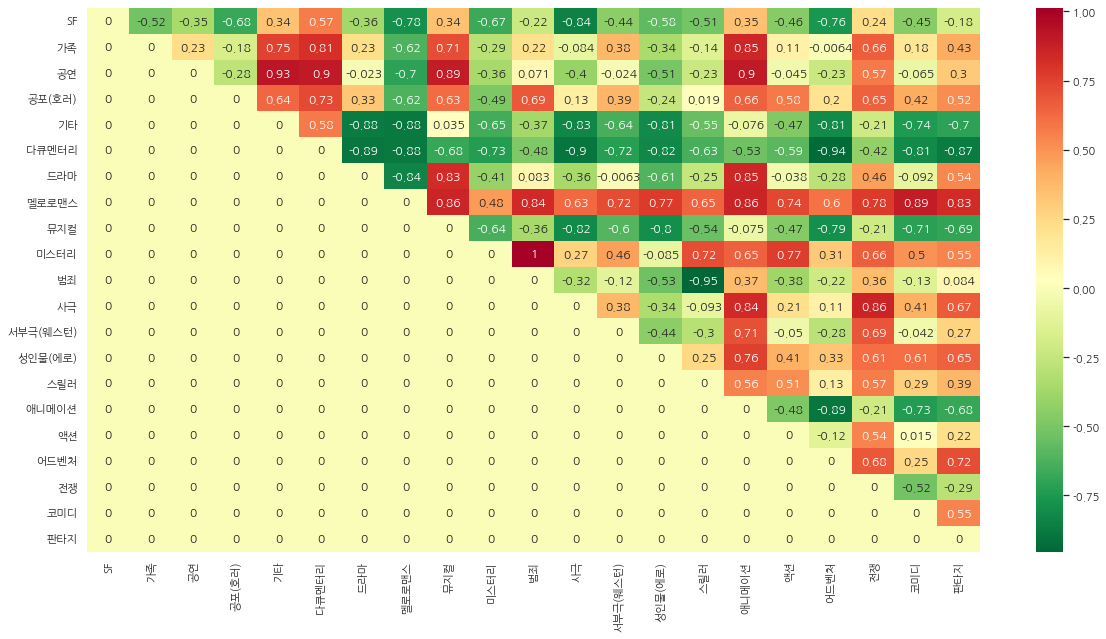

In [ ]:
import numpy as np; 
import seaborn as sns; 
import matplotlib.pyplot as plt

np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 
plt.figure(figsize=(20,10))
plt.rcParams['axes.unicode_minus'] = False

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

1. WEAT SCORE는 단어 임베딩 간 편향성을 측정하는 좋은 방법인가?
2. 무엇보다 해당 노드에서 상업영화 - 예술영화를 상반된 attribute로 설정한 것에 대한 모호함이 존재한다.
3. 즉 상업영화와 예술영화는 과연 상반된 attribute인가를 일차적으로 물어야만 하며,
4. 나아가 두번째로 genre는 과연 독립적으로 구분되어질 수 있는 것인가?
5. 혹은 해당 영화의 시놉시스는 과연 해당 영화의 장르적 특성들을 잘 담고있는 데이터인가?
6. 하고싶은말은 해당 Score를 시각화한 결과에 납득할 수 없다.... 실제 우리의 세계에 편향성이 존재하고, 그러한 현실의 코퍼스를 통해 얻어진 임베딩 결과 역시 '편향적'이지만, 해당 시각화 결과가 우리 세계에 이미 존재하던 편향성 혹은 단어 임베딩 간의 편향성을 드러내는데 충분하지 않은 이유는 앞서 주어진 전제들을 만족하지 못하였기 때문이라 잠정적으로 결론지을 수 있다.
7. 결론적으로 앞서 세 가지의 전제가 만족이 되지 않은 상태에서 제대로 된 장르간 편향성을 구해볼 수 있는가?
8. 그러므로 Embedding 간의 편향성을 구하는 과정에서 주요한 것은 적절한 attribute와 target을 설정하는 작업이라 할 수 있다. 
